#### Imports & Globals

In [1]:
from os import getcwd
from os.path import abspath, dirname, join

from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
from imutils.convenience import resize, adjust_brightness_contrast
import imutils
import numpy as np
import cv2
import dlib

from matplotlib import pyplot as plt
from time import sleep

# Local
from src.lowpolify import helper

In [79]:
def create_blank(width, height, rgb_color=(0, 0, 0)):
    """Create new image(numpy array) filled with certain color in RGB"""
    image    = np.zeros((height, width, 3), np.uint8)
    image[:] = tuple(reversed(rgb_color))
    return image

def splitImageLeft(src):
    height, width, depth = src.shape
    median_height = height // 2
    median_width  = width // 2
    return src[0:height, 0:median_width]

def splitImageRight(src):
    height, width, depth = src.shape
    median_height = height // 2
    median_width  = width // 2
    return src[0:height, median_width:width]

def splitImageTop(src):
    height, width, depth = src.shape
    median_height = height // 2
    median_width  = width // 2
    return src[0:median_height, 0:width]

def splitImageBottom(src):
    height, width, depth = src.shape
    median_height = height // 2
    median_width  = width // 2
    return src[median_height:height, 0:width]

def combineColorImages(img1, img2, horizontal=True):
    # Dimensions
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    #create empty matrix
    dh  = max(h1, h2) if horizontal else h1 + h2
    dw  = w1 + w2     if horizontal else max(w1, w2)
    vis = np.zeros((dh, dw, 3), np.uint8)

    #combine 2 images
    if (horizontal):
        vis[0:dh, 0:w1,  :3] = img1
        vis[0:dh, w1:dw, :3] = img2
    else:
        vis[0:h1,  0:dw, :3] = img1
        vis[h1:dh, 0:dw, :3] = img2

    return vis

In [2]:
IMGDIR    = join(abspath(getcwd()), "src", "imgs")

# DLIB
dat_path  = join(IMGDIR, "shape_predictor_68_face_landmarks.dat")
predictor = dlib.shape_predictor(dat_path)
detector  = dlib.get_frontal_face_detector()

# Raw
before_raw_path = join(IMGDIR, "before.jpg")
after_raw_path  = join(IMGDIR, "after.jpg")

# Cropped, aligned
before_crop_path = join(IMGDIR, "before_align.jpg")
after_crop_path  = join(IMGDIR, "after_align.jpg")

# Polygonized
before_poly_path = join(IMGDIR, "before_poly.jpg")
after_poly_path  = join(IMGDIR, "after_poly.jpg")

FACE_WIDTH = 1024
# 0.025 - too blocky
POLY_COEFFICIENT = 0.075

# For FaceMorpher
!export DLIB_DATA_DIR=IMGDIR

In [82]:
background = create_blank(900, 1200, (222, 222, 222))

### Low Polify

In [ ]:
helper(before_raw_path, POLY_COEFFICIENT, before_poly_path)

In [ ]:
helper(after_raw_path,  POLY_COEFFICIENT, after_poly_path)

In [64]:
DELTA_BRIGHTNESS = -10
DELTA_CONTRAST = -5

GRABCUT_ITERS = 15

In [5]:

before_poly = cv2.imread(before_poly_path)
after_poly  = cv2.imread(after_poly_path)

# needs to resize to polygon image size
before_raw  = cv2.imread(before_raw_path)
after_raw   = cv2.imread(after_raw_path)

before_raw = resize(before_raw, 900, 1200)
after_raw = resize(after_raw,   900, 1200)

before_raw = adjust_brightness_contrast(before_raw, DELTA_BRIGHTNESS, DELTA_CONTRAST)
after_raw  = adjust_brightness_contrast(after_raw,  DELTA_BRIGHTNESS, DELTA_CONTRAST)


"""
|---------|---------|
| NORM B4 | POLY AF |
|---------|---------|
| POLY B4 | NORM AF |
|_________|_________|

"""
# Left/ before
norm_b4 = splitImageTop(splitImageLeft(before_raw))
poly_b4 = splitImageBottom(splitImageLeft(before_poly))
comb_b4 = combineColorImages(norm_b4, poly_b4, False)

# Right / after
poly_af = splitImageTop(splitImageRight(after_poly))
norm_af = splitImageBottom(splitImageRight(after_raw))
comb_af = combineColorImages(poly_af, norm_af, False)

comb_all = combineColorImages(comb_b4, comb_af, True)
cv2.imwrite('combine-test-all.jpg', comb_all)

True

In [ ]:
"""
|---------|---------|
| NORM B4 | POLY B4 |
|_________|_________|

"""
# Left/ before
norm_b4 = splitImageLeft(before_raw)
poly_b4 = splitImageRight(before_poly)
comb_b4 = combineColorImages(norm_b4, poly_b4, True)

cv2.imwrite('combine-test-before.jpg', comb_b4)

In [ ]:
"""
|---------|---------|
| NORM AF | POLY AF |
|_________|_________|

"""
# Left/ before
norm_b4 = splitImageLeft(after_raw)
poly_b4 = splitImageRight(after_poly)
comb_b4 = combineColorImages(norm_b4, poly_b4, True)

cv2.imwrite('combine-test-after.jpg', comb_b4)

### GrabCut

In [65]:
# boundingbox rect needed
detections = detector(before_raw, 1)
shape = predictor(before_raw, detections[0])
grabCutRect = (
    shape.rect.left() - 50,
    # shape.rect.top() - 150, 354
    50,
    shape.rect.left() + shape.rect.width() + 50,
    shape.rect.bottom() + 50
)

mask = np.zeros(before_raw.shape[:2], dtype="uint8")


In [86]:
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")

# apply GrabCut using the the bounding box segmentation method
# (mask, bgModel, fgModel) = cv2.grabCut(before_raw, before_mask, grabCutRect, bgModel,
# 	fgModel, iterCount=GRABCUT_ITERS, mode=cv2.GC_INIT_WITH_RECT)

(mask, bgModel, fgModel) = cv2.grabCut(before_raw, before_mask, None, bgModel,
	fgModel, iterCount=15, mode=cv2.GC_INIT_WITH_MASK)

[INFO] showing mask for 'Definite Background'


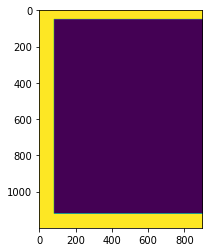

[INFO] showing mask for 'Probable Background'


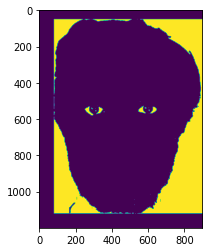

[INFO] showing mask for 'Definite Foreground'


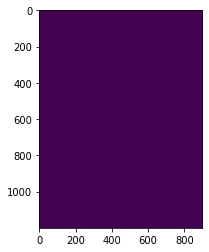

[INFO] showing mask for 'Probable Foreground'


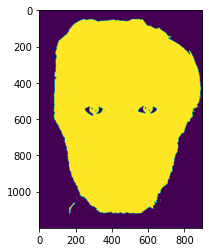

In [87]:
values = (
	("Definite Background", cv2.GC_BGD),
	("Probable Background", cv2.GC_PR_BGD),
	("Definite Foreground", cv2.GC_FGD),
	("Probable Foreground", cv2.GC_PR_FGD),
)
# loop over the possible GrabCut mask values
for (name, value) in values:
    # construct a mask that for the current value
    print("[INFO] showing mask for '{}'".format(name))
    valueMask = (mask == value).astype("uint8") * 255
    plt.imshow(valueMask)
    plt.show()

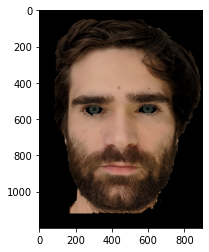

In [78]:
outputMask = np.where(
    (mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1)
# scale the mask from the range [0, 1] to [0, 255]
outputMask = (outputMask * 255).astype("uint8")
# apply a bitwise AND to the image using our mask generated by
# GrabCut to generate our final output image
output = cv2.bitwise_and(before_raw, before_raw, mask=outputMask)

plt.imshow(output[:, :, ::-1])

In [70]:
# LearnOpenCV segmentations

def decode_segmap(image, source, nc=21):
    # Load the foreground input image
    foreground = cv2.imread(source)
    # untouched?
    # foreground = source

    # Change the color of foreground image to RGB
    # and resize image to match shape of R-band in RGB output map
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    b, g, r = cv2.split(foreground)
    foreground = cv2.resize(foreground,(r.shape[1], r.shape[0]))

    # Create a background array to hold white pixels
    # with the same size as RGB output map
    background = 255 * np.ones_like(image).astype(np.uint8)

    # Convert uint8 to float
    foreground = foreground.astype(float)
    background = background.astype(float)

    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(foreground), 0, 255, cv2.THRESH_BINARY)

    # Apply a slight blur to the mask to soften edges
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float) / 255

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)

    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)

    # Add the masked foreground and background
    outImage = cv2.add(foreground, background)

    # Return a normalized output image for display
    return outImage / 255


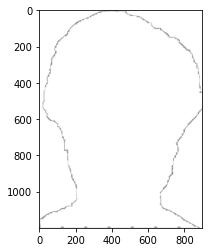

In [71]:
sample = decode_segmap(before_raw, before_mask_path)
plt.imshow(sample)

In [38]:
before_mask_path = join(IMGDIR, "before_mask.jpg")
before_mask = cv2.imread(before_mask_path)
before_mask = cv2.cvtColor(before_mask, cv2.COLOR_BGR2GRAY)
# before_mask = cv2.normalize(before_mask, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

before_mask[before_mask == 0] = cv2.GC_BGD
before_mask[before_mask == 255] = cv2.GC_FGD

# plt.imshow(before_mask)
before_mask


array([[  1,   1,   1, ...,   1,   1,   1],
       [  1,   1,   1, ...,   1,   1,   1],
       [  1,   1,   1, ...,   1,   1,   1],
       ...,
       [  1, 250,   1, ...,   1,   1,   1],
       [254,   1, 254, ...,   1,   1,   1],
       [  1, 253,   1, ...,   1,   1,   1]], dtype=uint8)

In [10]:
!ls src/imgs/

after.jpg	before_mask.jpg    shape_predictor_68_face_landmarks.dat
after_poly.jpg	before_poly04.png  shape_predictor_68_face_landmarks.dat.bz2
before.jpg	before_poly.jpg


### Persist Cropped Before

In [88]:
cv2.imwrite(before_crop_path, before_raw)
cv2.imwrite(after_crop_path, after_raw)

True